In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
%matplotlib inline

In [3]:
base_dir = "C:/Users/joanc/PycharmProjects/face_detection/"

In [28]:
def plot_single_img(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
        plt.show()

In [37]:
def slide_window(img, window_size=36):
    h, w = img.shape
    for i in range(0, h-window_size):
        for j in range(0, w):
            yield img[i:i+window_size, j:j+window_size]

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


img = np.array(Image.open(base_dir+"dataset/train_images/1/Image000644.jpg"))

(43, 43)
2
In


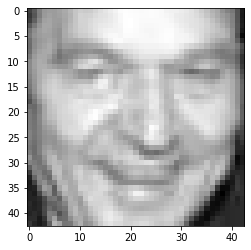

In [38]:
def zoom(img, factor=1.2):
    return cv2.resize(img, dsize=None,fx=factor, fy=factor)

zoomed = zoom(img)
print(zoomed.shape)
plot_single_img(zoomed)

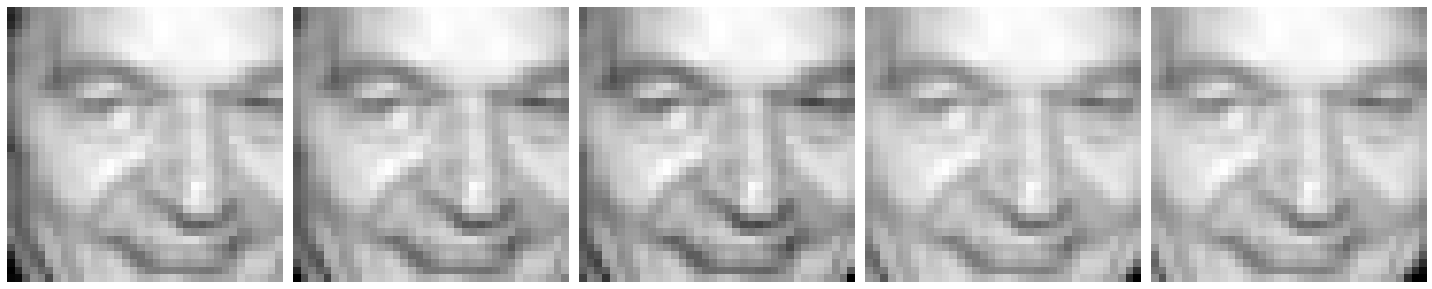

In [39]:
gen = slide_window(zoomed)
l = [next(gen) for it in range(5)]
plot_images(l)

In [45]:
def predict_pyramid(model, img, zoom_factor=1.2, window_size=36): 
    for it in range(10):
        img = zoom(img, zoom_factor)
        slider = slide_window(img, window_size)
        for window in slider:
            model.predict([window])
            
model = load_model("saved_models/face_classifier.h5")
predict_pyramid(model, img)

ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (36, 36)